In [10]:

# LSTM model dummy
# Dummy model to predict the climate time series data

# !nvidia-smi

import tensorflow as tf 
# !pip install tensorflow-gpu
print(tf.__version__)

print('1: ', tf.config.list_physical_devices('GPU'))


2.11.0
1:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tabloo
from tensorflow import keras
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout, Bidirectional, RepeatVector, TimeDistributed
import math
from sklearn.metrics import mean_squared_error

## Data Processing

### Data Fetching and Cleaning

In [12]:
#getting data and sorting it into all the present IDs

scaler = MinMaxScaler()
df_normal = pd.read_csv('SynCAN/train_1.csv', delimiter=',')
df_normal = df_normal.dropna(axis=1, how='all')
df_normal[['Time']] = scaler.fit_transform(df_normal[['Time']])

# all_IDs = np.array(df_normal.groupby(['ID']).count().index.values)
# print((np.sort(all_IDs)))
all_IDs = np.array(['id1','id5'])
print(all_IDs)
df_ID_list = list()
for i in all_IDs:
    temp = df_normal[df_normal['ID']==i].dropna(axis=1, how='all')
    temp = temp.drop(temp[['Label']],axis =1)
    temp = temp.drop(temp[['ID']],axis =1)
    temp = temp.iloc[0:100000,0:2]
    df_ID_list.append(temp)

for i in range(len(df_ID_list)):
    # tabloo.show(i)
    print(len(df_ID_list[i]))
    print(df_ID_list[i])

['id1' 'id5']
100000
                Time   Signal1
5       7.768963e-07  0.000000
12      1.743012e-06  0.000000
20      2.709128e-06  0.000000
27      3.675243e-06  0.000000
33      4.641359e-06  0.000000
...              ...       ...
716667  9.661890e-02  0.824540
716672  9.661986e-02  0.824310
716680  9.662083e-02  0.824080
716687  9.662180e-02  0.823829
716695  9.662276e-02  0.823559

[100000 rows x 2 columns]
100000
                Time   Signal1
0       0.000000e+00  0.000000
6       9.661157e-07  0.000000
13      1.932231e-06  0.000000
21      2.898347e-06  0.000000
28      3.864463e-06  0.000000
...              ...       ...
716661  9.661843e-02  0.187579
716669  9.661939e-02  0.187527
716675  9.662036e-02  0.187474
716683  9.662133e-02  0.187417
716690  9.662229e-02  0.187356

[100000 rows x 2 columns]


In [13]:
df_ID_list[1]['Signal1']

0         0.000000
6         0.000000
13        0.000000
21        0.000000
28        0.000000
            ...   
716661    0.187579
716669    0.187527
716675    0.187474
716683    0.187417
716690    0.187356
Name: Signal1, Length: 100000, dtype: float64

['id1' 'id5']
2791
            Time  Signal1_of_ID
180001  0.000034       0.607940
180008  0.000392       0.608011
180014  0.000751       0.608101
180023  0.001109       0.608181
180029  0.001467       0.608261
...          ...            ...
199967  0.998421       0.588852
199976  0.998779       0.588862
199981  0.999138       0.588832
199990  0.999496       0.588762
199996  0.999854       0.588672

[2791 rows x 2 columns]
2791
            Time  Signal1_of_ID
180002  0.000162       0.138320
180010  0.000521       0.138340
180016  0.000879       0.138358
180025  0.001237       0.138377
180030  0.001596       0.138402
...          ...            ...
199970  0.998514       0.193639
199977  0.998872       0.196394
199983  0.999230       0.199140
199992  0.999589       0.201689
199998  0.999947       0.204236

[2791 rows x 2 columns]


Text(0.5, 1.0, 'Plateau Attack (180000-190000) values')

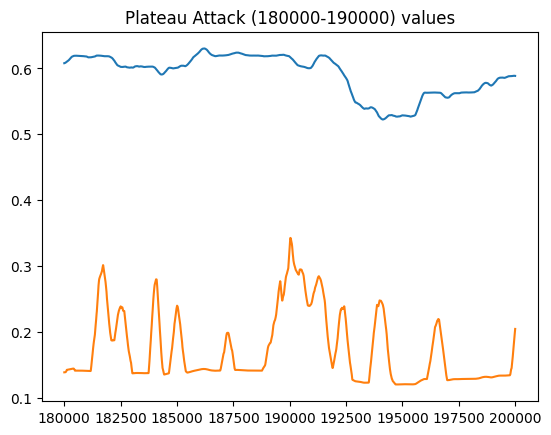

In [14]:
df_test_plat_ID1 = pd.read_csv('SynCAN/test_plateau.csv', delimiter=',')
df_test_plat_ID1 = df_test_plat_ID1.dropna(axis=1, how='all')
# df_test_plat_ID1 = df_test_plat_ID1.iloc[0:(int(len(df_test_plat_ID1)/5)),:]
df_test_plat_ID1 = df_test_plat_ID1.iloc[180000:200000,:]
df_test_plat_ID1[['Time']] = scaler.fit_transform(df_test_plat_ID1[['Time']])

# df_test_plat_ID1.iloc[180000:250000,0:2]

all__test_IDs = np.array(['id1','id5'])
print(all_IDs)
df_testID_list = list()

for i in all__test_IDs:
    tempTest = df_test_plat_ID1[df_test_plat_ID1['ID']==i].dropna(axis=1, how='all')
    tempTest = tempTest.drop(tempTest[['Label']],axis =1)
    tempTest = tempTest.drop(tempTest[['ID']],axis =1)
    tempTest = tempTest.iloc[0:100000,0:2]
    df_testID_list.append(tempTest)

for i in range(len(df_testID_list)):
    # tabloo.show(i)
    print(len(df_testID_list[i]))
    print(df_testID_list[i])


plt.plot(df_testID_list[0].iloc[:,1:2])
plt.plot(df_testID_list[1].iloc[:,1:2])
plt.title('Plateau Attack (180000-190000) values')

In [15]:


# create a test dataset of 30 sequences from the provided Data
def createTestDataset(x,y,time_step):
    Xs,Ys = [],[]
    for j in range(len(x)):
        v = []
        p = []
        for i in range(len(x[j])-time_step):
            y = x[j]['Signal1_of_ID'].iloc[i:i+time_step].values
            v.append(y)
            p.append(x[j]['Signal1_of_ID'].iloc[i+time_step])
        Xs.append(v)
        Ys.append(p)
    
    # print(Xs)
    # print(Ys)
            
    return np.array(Xs),np.array(Ys)
    

In [16]:


# create a dataset of 30 sequences from the provided Data
def creatDataset(x,y,time_step):
    Xs,Ys = [],[]
    for j in range(len(x)):
        v = []
        p = []
        for i in range(len(x[j])-time_step):
            y = x[j]['Signal1'].iloc[i:i+time_step].values
            v.append(y)
            p.append(x[j]['Signal1'].iloc[i+time_step])
        Xs.append(v)
        Ys.append(p)
    
    # print(Xs)
    # print(Ys)
            
    return np.array(Xs),np.array(Ys)
    

In [17]:
TIME_STEP = 30
X_train, Y_train = creatDataset(df_ID_list, df_ID_list, TIME_STEP)
X_test, Y_test = createTestDataset(df_testID_list, df_testID_list, TIME_STEP)

# X_train.shape

# X_test.shape

In [18]:
print(X_train.shape)
print(Y_train.shape)

(2, 99970, 30)
(2, 99970)


In [19]:
print(X_test.shape)
print(Y_test.shape)

(2, 2761, 30)
(2, 2761)


In [74]:
a = np.reshape(X_train,(-1,2,30))
b = np.reshape(Y_train,(-1,2))

print(a.shape)
print(b.shape)

(99970, 2, 30)
(99970, 2)


In [75]:
p = np.reshape(X_test,(-1,2,30))
q = np.reshape(Y_test,(-1,2))
print(p.shape)
print(q.shape)

(2761, 2, 30)
(2761, 2)


In [76]:
print(a.shape)
print(a)

(99970, 2, 30)
[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 ...

 [[0.18904338 0.18902971 0.18901376 ... 0.18779092 0.18773627 0.18768162]
  [0.18902971 0.18901376 0.18899326 ... 0.18773627 0.18768162 0.18763152]]

 [[0.18901376 0.18899326 0.18897049 ... 0.18768162 0.18763152 0.18757913]
  [0.18899326 0.18897049 0.18894543 ... 0.18763152 0.18757913 0.18752675]]

 [[0.18897049 0.18894543 0.18891356 ... 0.18757913 0.18752675 0.18747438]
  [0.18894543 0.18891356 0.18888166 ... 0.18752675 0.18747438 0.18741745]]]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2, 30, 128)       66560     
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2, 3840)          0         
 tributed)                                                       
                                                                 
 dense (Dense)               (None, 2, 512)            1966592   
                                                                 
 dense_1 (Dense)             (None, 2, 256)            131328    
                                                                 
 time_distributed_2 (TimeDis  (None, 2, 30)            7710      
 tributed)                                                       
                                                        

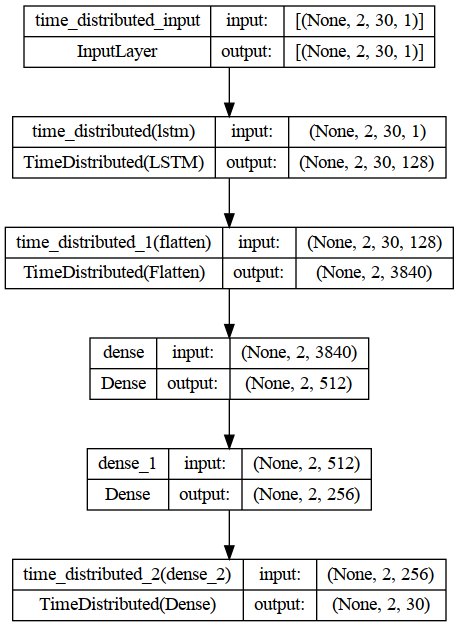

In [ ]:


# n_features = X_train.shape[2]
model= Sequential()
model.add(
    TimeDistributed(
        LSTM(128, activation='relu', return_sequences = True), 
        input_shape=(2,30,1) #all IDs LSTMs 
    )
)

model.add(
    TimeDistributed(
        Flatten() 
    )
)
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(TimeDistributed(Dense(30)))
model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()
plot_model(model, to_file='model_plot.png', 
           show_shapes=True, show_layer_names=True,
           show_layer_activations=False, expand_nested=True)

#### Model Fitting

In [24]:
# fit model
model.fit(a, b, epochs=15, batch_size=30, validation_split=0.1, shuffle=False)
model.save("single_ID_LSTM_autoenc")

Epoch 1/15


2023-03-18 13:07:32.305701: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x90d8720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-18 13:07:32.305730: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA T500, Compute Capability 7.5
2023-03-18 13:07:32.318015: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-18 13:07:32.482466: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


KeyboardInterrupt: 

#### Training loss, finding Threshold

In [78]:
reconstructed_model = keras.models.load_model("single_ID_LSTM_autoenc")

In [ ]:
x_train_predict = reconstructed_model.predict(a, verbose=0)
a_train_predict = np.reshape(x_train_predict,(2,30,-1))
a_predict = np.reshape(a,(2,30,-1))
x_train_predict.shape
a_predict = np.reshape(x_train_predict,(-1,2,30,1))
train_mae_loss = np.mean(np.abs(a_predict - a), axis=1)
sns.distplot(train_mae_loss,bins=50,kde=True )
print("a Predict  = \n")
print(a_predict)
print("a original  = \n")
print(a)

### Test Loss

p Predict  = 

(2, 30, 2761)
p original  = 

(2761, 2, 30)
Test Loss  = 

(2761, 2)


/tmp/ipykernel_3018/2717381309.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_mae_loss,bins=50,kde=True )


<Axes: ylabel='Density'>

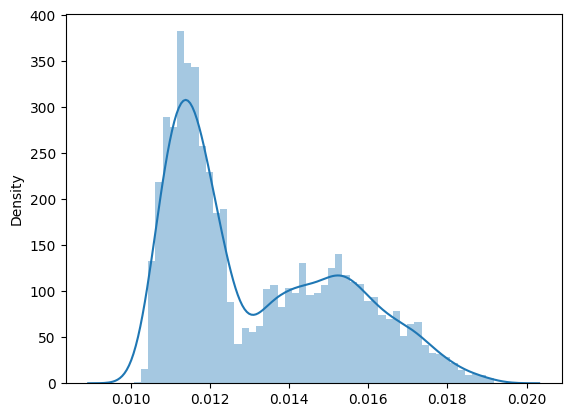

In [112]:
THRESHOLD = 0.05

x_test_predict = reconstructed_model.predict(p, verbose=0)
p_test_predict = np.reshape(x_test_predict,(2,30,-1))
p_predict = np.reshape(p,(2,30,-1))
test_mae_loss = np.mean(np.abs(p_test_predict - p_predict), axis=1)
test_mae_loss = np.reshape(test_mae_loss,(-1,2))
# sns.distplot(train_mae_loss,bins=50,kde=True )
print("p Predict  = \n")
print(p_predict.shape)
print("p original  = \n")
print(p.shape)
print("Test Loss  = \n")
print(test_mae_loss.shape)
sns.distplot(test_mae_loss,bins=50,kde=True )


### Test Score Dataframe Creation and plotting


In [81]:
print(p.shape)
print(x_test_predict.shape)
print(p_predict.shape)
print(test_mae_loss.shape)
print(p_predict)
print(test_mae_loss)


(2761, 2, 30)
(2761, 2, 30)
(2761, 30, 2)
(2761, 30)
[[[0.60004914 0.5995057 ]
  [0.59884816 0.59892905]
  [0.5998079  0.59986705]
  ...
  [0.5992687  0.6001608 ]
  [0.60055214 0.60023665]
  [0.60037297 0.60251725]]

 [[0.6004744  0.5999302 ]
  [0.599272   0.5993515 ]
  [0.6002326  0.60029274]
  ...
  [0.5997082  0.60060245]
  [0.60099465 0.6006783 ]
  [0.6008154  0.60296535]]

 [[0.60093653 0.6003911 ]
  [0.5997328  0.5998106 ]
  [0.60069376 0.60075575]
  ...
  [0.60019547 0.60109204]
  [0.6014859  0.601167  ]
  [0.6013053  0.60346174]]

 ...

 [[0.19074869 0.19120829]
  [0.19103171 0.19089992]
  [0.19099657 0.19096515]
  ...
  [0.19433023 0.19449621]
  [0.19424534 0.19400516]
  [0.19409287 0.19420841]]

 [[0.19764659 0.19807838]
  [0.19795541 0.19771174]
  [0.19780344 0.19789547]
  ...
  [0.20105116 0.2012538 ]
  [0.2010474  0.20071352]
  [0.20080869 0.20094837]]

 [[0.20430212 0.2046895 ]
  [0.20460731 0.20436004]
  [0.20443772 0.20457032]
  ...
  [0.20757999 0.20776066]
  [0.207603

In [114]:
print(df_testID_list[0][TIME_STEP:].Time.shape)
print(test_mae_loss.shape)

(2761,)
(2761, 2)


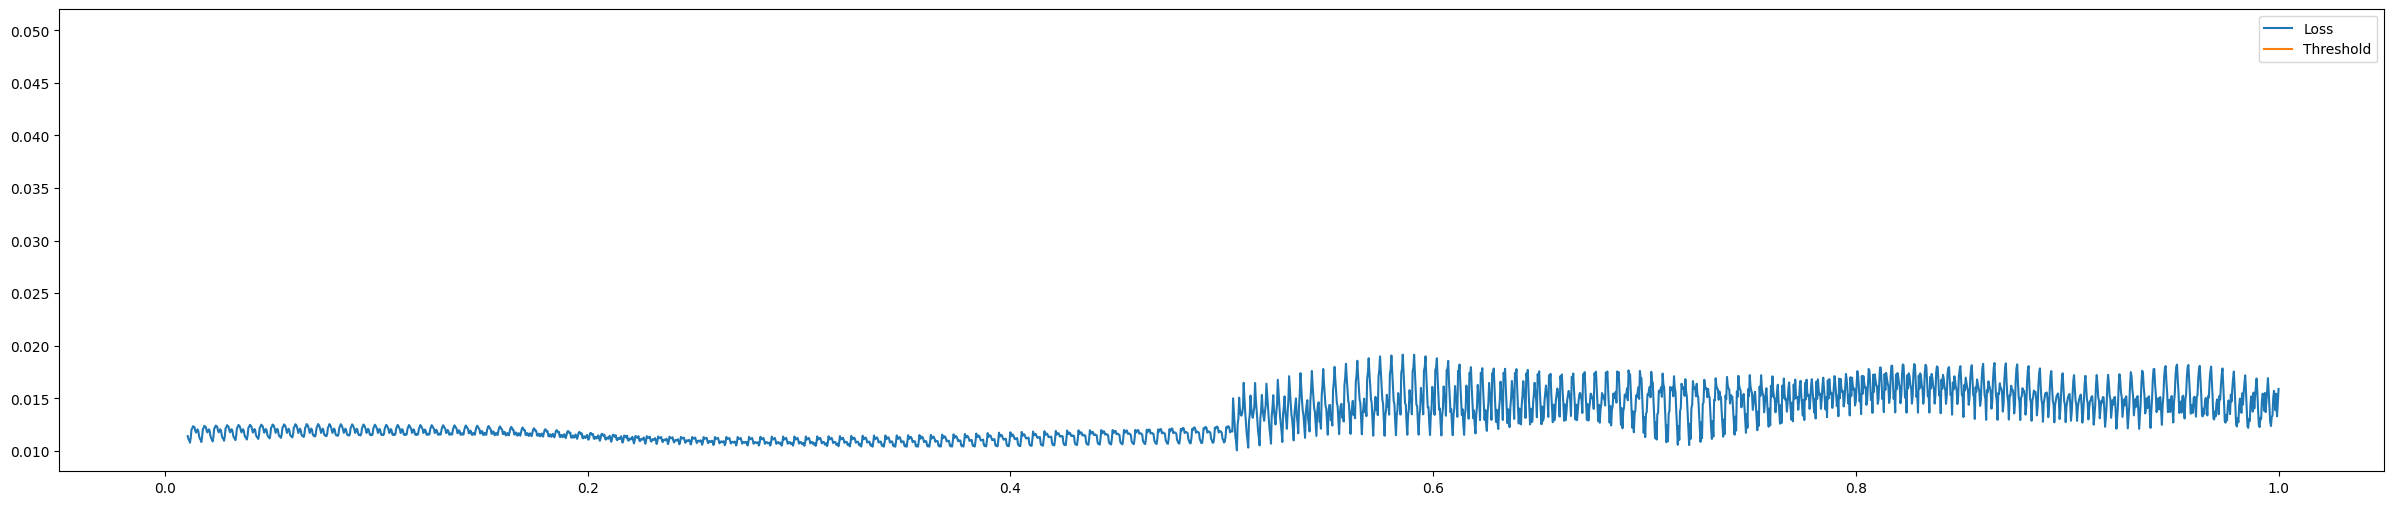

In [117]:
# #plot the threshoold vs the actual loss values
plt.figure(figsize=(30,6))
plt.plot(df_testID_list[0][TIME_STEP:].Time,test_mae_loss[:,1], label='Loss')
plt.plot(THRESHOLD, label='Threshold')
plt.legend()

In [28]:
test_score_df = pd.DataFrame(index=df_testID_list[0][TIME_STEP:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
print(test_score_df.threshold.shape)
print(test_score_df.loss.shape)
# test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
# test_score_df['Signal1_ID1'] = df_testID_list[0][TIME_STEP:].Signal1_of_ID
# test_score_df['Signal1_ID2'] = df_testID_list[1][TIME_STEP:].Signal1_of_ID


# #plot the threshoold vs the actual loss values
# plt.plot(test_score_df.index, test_score_df.loss, label='Loss')
# plt.plot(test_score_df.index, test_score_df.threshold, label='Threshold')
# plt.legend()


# df['meantemp'].plot()
# df['humidity'].plot()
# plt.legend(['Sig1','Sig2'])

# train_set=df[:'2016'].iloc[:,0]
# test_set=df['2016':].iloc[:,0]
# df_normal_grp_ID1['Signal1_of_ID'].head()
# plt.plot(df_normal_grp_ID1['Time'],df_normal_grp_ID1['Signal1_of_ID'])
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[0:500,:]
# fig = 
# len(df_normal_grp_ID1)
# df_normal_grp_ID1['Signal1'].plot()

(2761,)
(30, 1)


In [29]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

AttributeError: 'DataFrame' object has no attribute 'anomaly'

In [ ]:
plt.plot(
  df_test_plat_ID1[TIME_STEP:].index, 
  df_test_plat_ID1[TIME_STEP:].Signal1_of_ID, 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  anomalies.Signal1,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.legend();